In [2]:
!pip install pennylane scikit-learn pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 85.1 MB/s eta 0:00:00


In [3]:
import pennylane as qml
from pennylane.kernels import kernel_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
col_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df = pd.read_csv(url, header=None, names=col_names)

# Features and labels
X = df.drop(columns=['class']).values
y = df['class'].values

# Scale and reduce to 2D with PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)


In [20]:
import pennylane as qml
import numpy as np

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def feature_map(x1, x2):
    qml.RY(x1, wires=0)
    qml.RY(x2, wires=0)  # Single qubit encoding
    return qml.probs(wires=0)  # Measure only the first qubit

def quantum_kernel(x, y):
    return np.abs(np.vdot(feature_map(*x), feature_map(*y))) ** 2

# Example usage
x = [0.5, 0.1]
y = [0.6, 0.2]
print("Quantum Kernel Value:", quantum_kernel(x, y))


Quantum Kernel Value: 0.6201695276130268


In [13]:
X_train_small = X_train[:50]
y_train_small = y_train[:50]
X_test_small = X_test[:20]
y_test_small = y_test[:20]

**Train Classical SVM**

In [23]:
import time
start_time = time.time()

# Classical SVM with Grid Search
param_grid = {'C': [0.0001, 0.01, 0.1, 1, 10, 100, 1000]}
clf = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=7)
clf.fit(X_train_small, y_train_small)

# Predictions and accuracy
y_pred_classical = clf.predict(X_test_small)
acc_classical = accuracy_score(y_test_small, y_pred_classical)

# End time
end_time = time.time()

# Calculate time of execution
execution_time = end_time - start_time

# Print results
print("Classical SVM Accuracy:", acc_classical)
print("Best C:", clf.best_params_['C'])
print("Classification Report (Classical):\n", classification_report(y_test_small, y_pred_classical))
print("Time of execution: {:.4f} seconds".format(execution_time))

Classical SVM Accuracy: 0.7
Best C: 100
Classification Report (Classical):
               precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.67      0.50      0.57         8

    accuracy                           0.70        20
   macro avg       0.69      0.67      0.67        20
weighted avg       0.70      0.70      0.69        20

Time of execution: 0.1959 seconds


In [15]:
X_train_kernel = kernel_matrix(X_train_small, X_train_small, kernel=quantum_kernel)
X_test_kernel = kernel_matrix(X_test_small, X_train_small, kernel=quantum_kernel)


In [24]:
start_time = time.time()

# Tune C using grid search
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(SVC(kernel='precomputed'), param_grid=param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_kernel, y_train_small)

# Best C
print("Best C:", grid.best_params_['C'])

# Predict and evaluate
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_kernel)

# Print results
print("Accuracy:", accuracy_score(y_test_small, y_pred))
print("Classification Report:\n", classification_report(y_test_small, y_pred))

# End time
end_time = time.time()

# Calculate time of execution
execution_time = end_time - start_time
print("Time of execution: {:.4f} seconds".format(execution_time))

Best C: 10
Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.50      0.25      0.33         8

    accuracy                           0.60        20
   macro avg       0.56      0.54      0.52        20
weighted avg       0.57      0.60      0.56        20

Time of execution: 0.0446 seconds


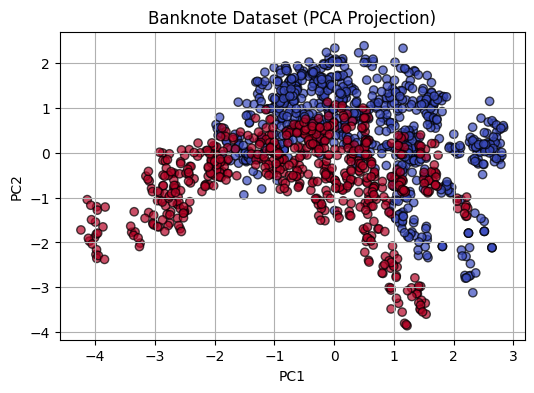

In [17]:
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Banknote Dataset (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
